In [2]:
%pip install cryptography

Note: you may need to restart the kernel to use updated packages.


In [3]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.serialization import Encoding, ParameterFormat, PublicFormat
from cryptography.hazmat.primitives.serialization import load_pem_parameters, load_pem_public_key
from cryptography.hazmat.primitives.kdf.hkdf import HKDF

In [4]:
with open ("shared_file", "rb") as file:
    parameters = load_pem_parameters(file.read()) 
    
private_key_D = parameters.generate_private_key() # Blue
public_mixed_with_D = private_key_D.public_key()  # light-blue-green

with open("shared_file", "wb") as file:
    file.write(public_mixed_with_D.public_bytes(encoding=Encoding.PEM, format=PublicFormat.SubjectPublicKeyInfo))

In [5]:
with open ("shared_file", "rb") as file:
    public_mixed_with_C = load_pem_public_key(file.read()) 

In [6]:
shared_key_C_then_D = private_key_D.exchange(public_mixed_with_C) # brown

derived_key_C_then_D = HKDF(
    algorithm = hashes.SHA256(),
    length=32,
    salt=None,
    info=b'handshake data',
    backend=default_backend()
).derive(shared_key_C_then_D)

print(derived_key_C_then_D)

b'\xaf8Z5\xf23\xfa\x95\xdb\x9c\xba\xf4\x81\x95)\xf7\xf3\x850\xcc\xa4\xaal\xa9\xdb\x07y\xd5\xb9~\xcd\x13'


### Decryption without Integrity and Authenticity

In [7]:
from Crypto.Cipher import AES
from Crypto.Util import Counter
from io import StringIO
import pandas as pd

In [8]:
with open ("shared_file", "rb") as file:
    columns_desc_enc = file.read()

In [9]:
def decrypt_csv_ctr(ct, key, counter_iv, counter_size=128):
    counter = Counter.new(counter_size, initial_value=counter_iv)    
    aes = AES.new(key=key, mode=AES.MODE_CTR, counter=counter)
    return aes.decrypt(ct)

pd.read_csv(StringIO(decrypt_csv_ctr(columns_desc_enc, derived_key_C_then_D, 10).decode('utf-8')))

,New name,Description
0,address,Client's address
1,age,Client's age in days at the time of application
2,annual_income,Income of the client
3,appendix_a,Did client provide document 2
4,appendix_b,Did client provide document 3
...,...,...
62,provided_workphone,"Did client provide work phone (1=YES, 0=NO)"
63,region_rating,Our rating of the region where client lives (1...
64,score_ext_1,Normalized score from external data source
65,score_ext_2,Normalized score from external data source


In [10]:
with open ("shared_file", "rb") as file:
    infringement_dataset_enc = file.read()

pd.read_csv(StringIO(decrypt_csv_ctr(infringement_dataset_enc, derived_key_C_then_D, 10).decode('utf-8')))

,loan_id,infringed,contract_type,gender,has_own_car,has_own_realty,num_children,annual_income,credit_amount,credit_annuity,...,SK_ID_CURR,avg_days_decision,past_avg_amount_annuity,past_avg_amt_application,past_avg_amt_credit,past_loans_approved,past_loans_refused,past_loans_canceled,past_loans_unused,past_loans_total
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,100002.0,606.000000,9251.775000,179055.000,179055.00,1.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,100003.0,1305.000000,56553.990000,435436.500,484191.00,3.0,0.0,0.0,0.0,3.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,100004.0,815.000000,5357.250000,24282.000,20106.00,1.0,0.0,0.0,0.0,1.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,100006.0,272.444444,23651.175000,272203.260,291695.50,5.0,3.0,1.0,0.0,9.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,100007.0,1222.833333,12278.805000,150530.250,166638.75,6.0,0.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,456251.0,273.000000,6605.910000,40455.000,40455.00,1.0,0.0,0.0,0.0,1.0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,456252.0,2497.000000,10074.465000,57595.500,56821.50,1.0,0.0,0.0,0.0,1.0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,456253.0,2380.000000,4770.405000,24162.750,20625.75,2.0,0.0,0.0,0.0,2.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,456254.0,299.500000,10681.132500,121317.750,134439.75,2.0,0.0,0.0,0.0,2.0


### Decryption with Integrity and Authenticity

In [11]:
from cryptography.hazmat.primitives.ciphers.aead import AESGCM
from io import StringIO
import pandas as pd

In [12]:
with open ("shared_file", "rb") as file:
    columns_desc_enc = file.read()

In [13]:
with open ("shared_file", "rb") as file:
    nonce = file.read()

aesgcm = AESGCM(derived_key_C_then_D)
pd.read_csv(StringIO(aesgcm.decrypt(nonce, columns_desc_enc, None).decode("utf-8")))

,New name,Description
0,address,Client's address
1,age,Client's age in days at the time of application
2,annual_income,Income of the client
3,appendix_a,Did client provide document 2
4,appendix_b,Did client provide document 3
...,...,...
62,provided_workphone,"Did client provide work phone (1=YES, 0=NO)"
63,region_rating,Our rating of the region where client lives (1...
64,score_ext_1,Normalized score from external data source
65,score_ext_2,Normalized score from external data source


In [14]:
with open ("shared_file", "rb") as file:
    infringement_dataset_enc = file.read()

In [15]:
with open ("shared_file", "rb") as file:
    nonce = file.read()

infringement_dataset = pd.read_csv(StringIO(aesgcm.decrypt(nonce, infringement_dataset_enc, None).decode("utf-8")))

### Data analysis

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: infringed, Length: 307511, dtype: int64


<AxesSubplot: >

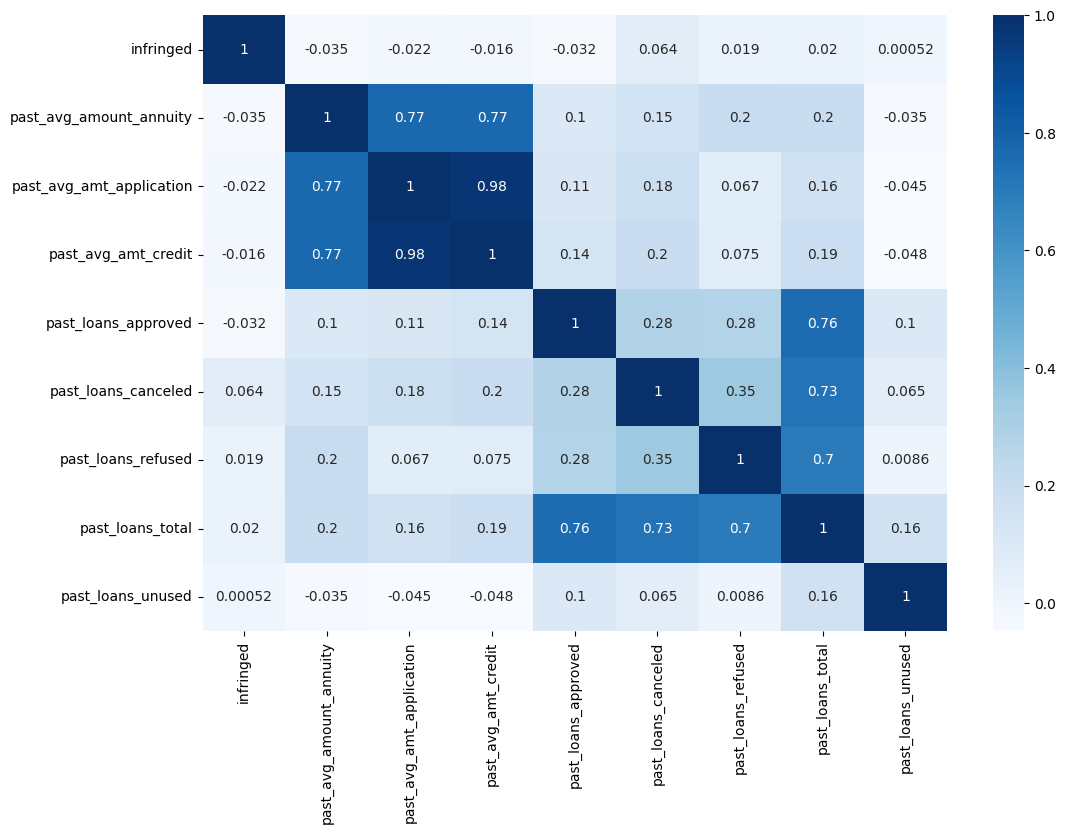

In [18]:
df = infringement_dataset[['infringed', 'past_avg_amount_annuity', 'past_avg_amt_application', 'past_avg_amt_credit', 'past_loans_approved', 'past_loans_canceled', 'past_loans_refused', 'past_loans_total', 'past_loans_unused']]

corr = df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Blues", annot=True)

age
21     142
22     401
23     522
24     431
25     420
26     476
27    1008
28     895
29     860
30     864
31     894
32     751
33     779
34     769
35     741
36     819
37     787
38     761
39     720
40     698
41     692
42     603
43     625
44     637
45     551
46     552
47     502
48     515
49     485
50     456
51     465
52     473
53     473
54     474
55     365
56     395
57     368
58     327
59     377
60     307
61     306
62     297
63     278
64     262
65     133
66      65
67      83
68      21
dtype: int64

age
20       1
21    1254
22    2933
23    4057
24    3905
25    4168
26    4561
27    8476
28    7975
29    7670
30    7806
31    8377
32    7911
33    7714
34    7631
35    7804
36    8614
37    8799
38    8873
39    8770
40    8624
41    8449
42    8216
43    8308
44    7819
45    7205
46    7293
47    7018
48    6984
49    6627
50    6482
51    6689
52    6763
53    7457
54    7551
55    6637
56    6828
57    6768
58    6268
59    6631
60    6227
61    5418
62    5514
63    5197
64    5117
65    3113
66    2085
67    2042
68     866
69      16
dtype: int64

<AxesSubplot: xlabel='age'>

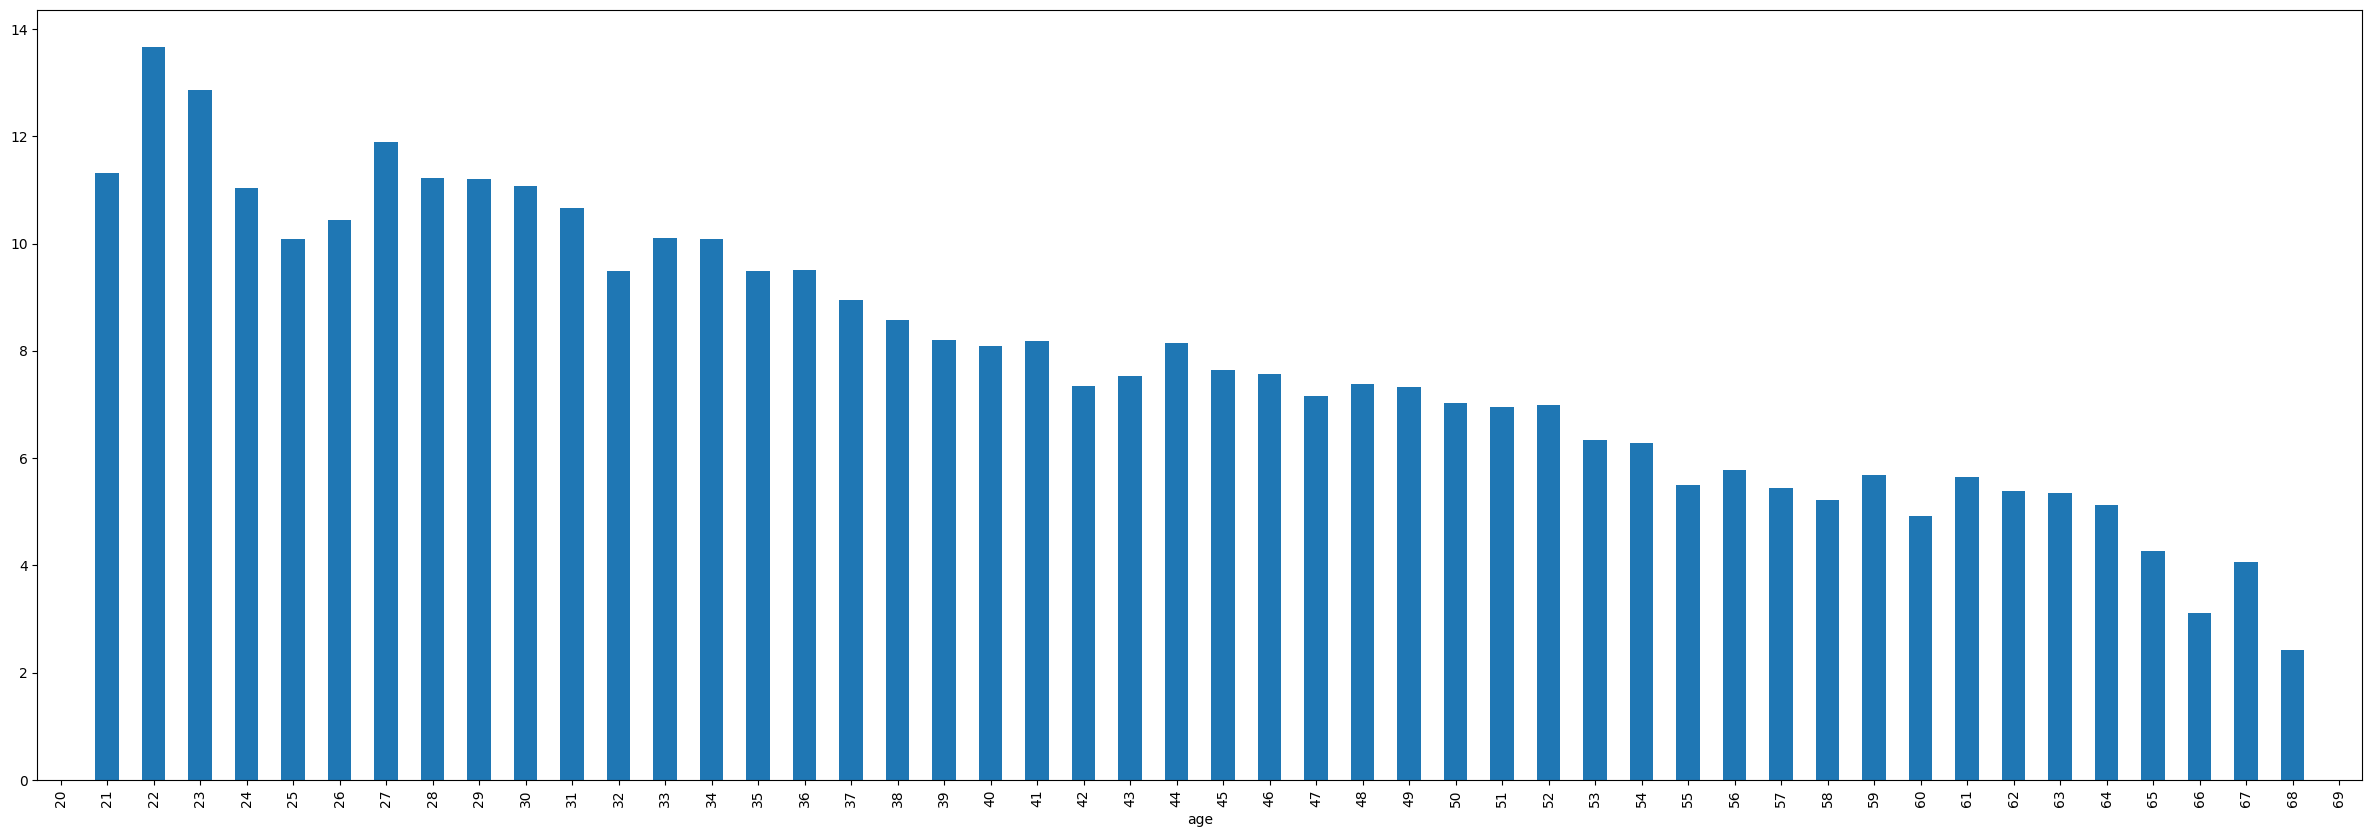

In [62]:
count_inf = infringement_dataset[infringement_dataset['infringed']==1.0].groupby(['age']).size()

age = infringement_dataset.groupby(['age']).size()

display(count_inf)

display(age)

((count_inf/age)*100).plot(figsize=(30,10), kind='bar')


num_family_members
1.0      5675
2.0     12009
3.0      4608
4.0      2136
5.0       327
6.0        55
7.0         6
8.0         6
10.0        1
11.0        1
13.0        1
dtype: int64

num_family_members
1.0      67847
2.0     158357
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
11.0         1
12.0         2
13.0         1
14.0         2
15.0         1
16.0         2
20.0         2
dtype: int64

<AxesSubplot: xlabel='num_family_members'>

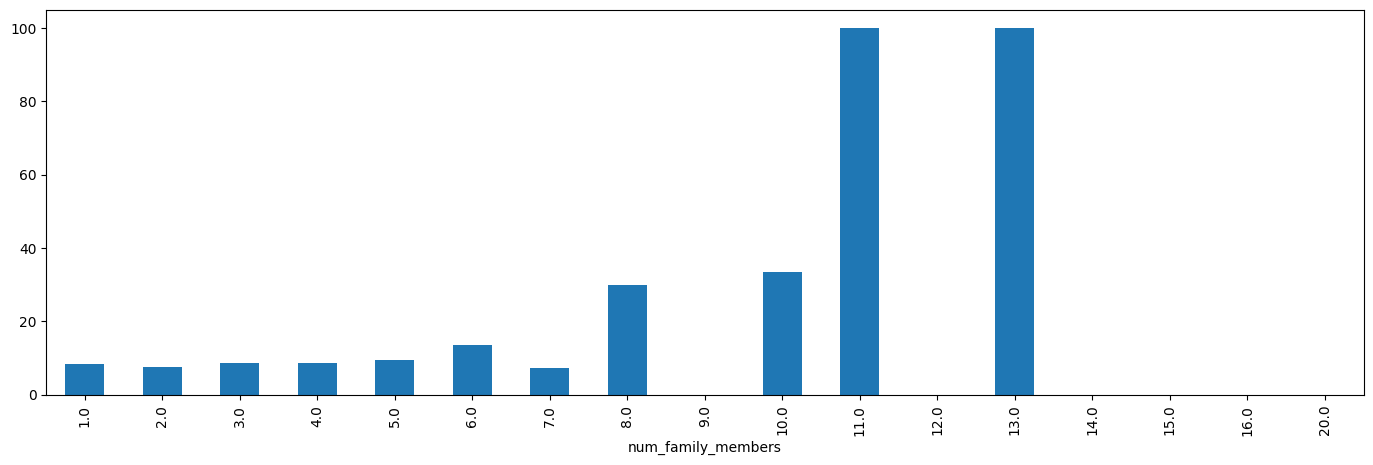

In [61]:
# count the values in the first column
import math
from turtle import color

count_inf = infringement_dataset[infringement_dataset['infringed']==1.0].groupby(['num_family_members']).size()

fam_with = infringement_dataset.groupby(['num_family_members']).size()

display(count_inf)

display(fam_with)


plt.figure(figsize=(17,5))
((count_inf/fam_with) * 100).plot(kind='bar') #numero de membros da familia para quem infringe